In [1]:
import pandas as pd
import json
import numpy as np
import pickle
from ast import literal_eval
from Gretel_path_prediction import GretelPathPrediction

import warnings
warnings.filterwarnings('ignore')

In [3]:
load_model = True
# Either load model from file...
if load_model:
    # load model from file
    model_path = '../../models/gretel_prediction_models/trained_models/202204_waypoints_DP10_HDBSCAN13_tromso_full_UTM.obj'
    fileObj = open(model_path, 'rb')
    model = pickle.load(fileObj)
    fileObj.close()
    
# ... or train model from scratch
else:
    directory = '../../models/gretel_prediction_models/tromso_small/'
    path_format = 'node2node'
    config_file = 'route_target'
    task = 'path'
    # load metadata file
    with open(directory+path_format+'/metadata.json', 'r') as json_file:
        meta_dict = json.load(json_file)
    meta_dict
    # train model
    model = GretelPathPrediction()
    model.train(config_file, directory, task)

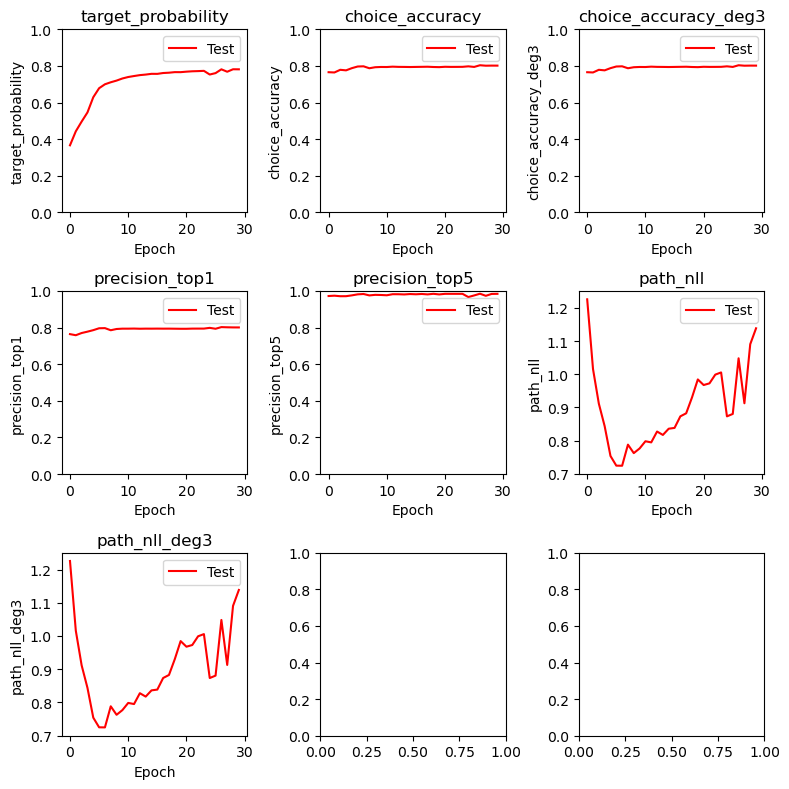

In [4]:
# plot training metrics
model.plot_train_test_metrics(test_only=True)

In [5]:
#start_node = 185
#end_node = 474
#node_dist, rw_weights = model.predict(start_node, end_node, 2)

In [6]:
# read network name from file
network_name = meta_dict['network_name']
# Load test data from file
test_dates = ['202206']
for i in range(0, len(test_dates)):
    test_date = test_dates[i]
    # Load path data
    filename = network_name+'_'+test_date+'_paths.csv'
    test_data = pd.read_csv('../../data/paths/'+filename)
    test_data['path'] = test_data['path'].apply(literal_eval)
    test_data = test_data[test_data['message']=='success']
    
    if i==0:
        all_test_data = test_data
    else:
        all_test_data = pd.concat([all_test_data, test_data])

all_test_data = all_test_data[['mmsi', 'path']]
# select test data
selection_start = 0
selection_end = len(test_data)
selection_step = 2
selection = np.arange(selection_start, selection_end, selection_step)
n_test_paths = len(selection)
test_data = all_test_data.iloc[selection]

In [7]:
n_walks = 200
result_list=[]
print(f'Making predictions for {n_test_paths} samples')
print(f'Progress:', end=' ', flush=True)
count = 0  # initialize a counter that keeps track of the progress
percentage = 0  # percentage of progress
for index, row in test_data.iterrows():
    mmsi = row['mmsi']
    path = row['path']
    start_node = path[0]
    end_node = path[-1]
    #print(start_node, end_node)
    prediction, flag = model.predict_path(start_node, end_node, max_path_length=150, n_predictions=1, n_walks=n_walks)
    #prediction = model.predict_next_nodes(start_node, n_steps=1, n_walks=n_walks)
    #flag = True
    if flag:
        predicted_path = [x for x in list(prediction)[0]]
        result_list.append({'mmsi': mmsi, 'ground_truth': tuple(path), 'prediction': tuple(predicted_path)})
    # report progress
    count += 1
    if count/len(test_data) > 0.1:
        count = 0
        percentage += 10
        print(f'{percentage}%...', end='', flush=True)
            
print('Done!')

result_df = pd.DataFrame(result_list)

Making predictions for 761 samples
Progress: 

KeyboardInterrupt: 

In [ ]:
# save results as csv
result_df.to_csv(directory+path_format+'/predictions.csv')

In [ ]:
# save metadata to file
meta_dict['lr'] = model.config.lr
meta_dict['loss'] = model.config.loss
meta_dict['n_epochs'] = model.config.number_epoch
meta_dict['target_prediction'] = model.config.target_prediction
meta_dict['n_walks'] = n_walks
meta_dict['model_type'] = 'Gretel'
meta_dict.update({'test_dates':str(test_dates),
                  'selection_start':selection_start,
                  'selection_end':selection_end,
                  'selection_step':selection_step,
                  'n_test_paths':n_test_paths})
with open(directory+path_format+'/metadata.json', 'w') as json_file:
    json.dump(meta_dict, json_file)

In [ ]:
'''
import pickle
# save model as pickle object
fileObj = open('../../models/gretel_prediction_models/trained_models/'+meta_dict['network_name']+'.obj', 'wb')
pickle.dump(model, fileObj)
fileObj.close()
'''